<a href="https://colab.research.google.com/github/Hrishikesh6666/GenAI_Langchain-for-Image-Creation-/blob/main/GenAI_Langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%pip install -U langchain-google-genai


In [4]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

Enter your Google AI API key: ··········


# Instantiation
Now we can instantiate our model object and generate chat completions:

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [6]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to Marathi. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content='मला प्रोग्रामिंग आवडते.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--1456a6e3-d9e2-457a-9055-8a0fb039a68f-0', usage_metadata={'input_tokens': 21, 'output_tokens': 392, 'total_tokens': 413, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 386}})

# Chaining
We can chain our model with a prompt template like so:

In [7]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "input_language": "English",
        "output_language": "Hindi",
        "input": "I love programming.",
    }
)

AIMessage(content='मुझे प्रोग्रामिंग करना बहुत पसंद है।', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--6e4c84f2-82a7-4cab-8026-56b0e8b418e3-0', usage_metadata={'input_tokens': 16, 'output_tokens': 812, 'total_tokens': 828, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 804}})

# **Image Generation (Multimodal Output)**
Certain models (such as gemini-2.0-flash-preview-image-generation) can generate text and images inline. You need to specify the desired response_modalities. See more information on the Gemini API docs for details.

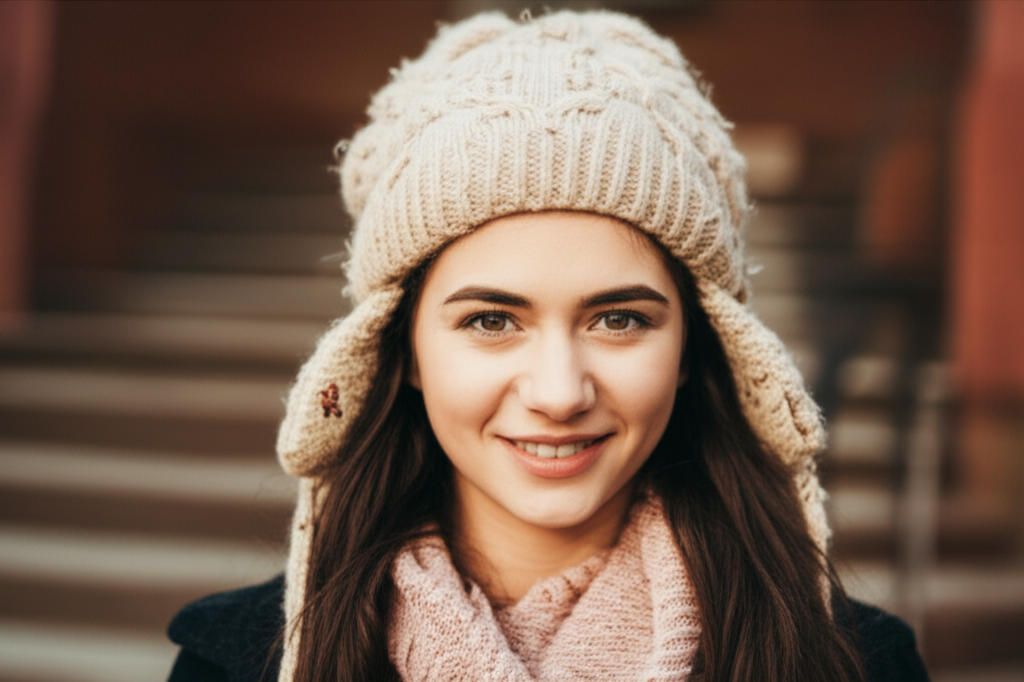

In [8]:
import base64

from IPython.display import Image, display
from langchain_core.messages import AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash-preview-image-generation")

message = {
    "role": "user",
    "content": "Generate a photorealistic image of a cuddly hot girl wearing a hat.",
}

response = llm.invoke(
    [message],
    generation_config=dict(response_modalities=["TEXT", "IMAGE"]),
)


def _get_image_base64(response: AIMessage) -> None:
    image_block = next(
        block
        for block in response.content
        if isinstance(block, dict) and block.get("image_url")
    )
    return image_block["image_url"].get("url").split(",")[-1]


image_base64 = _get_image_base64(response)
display(Image(data=base64.b64decode(image_base64), width=300))

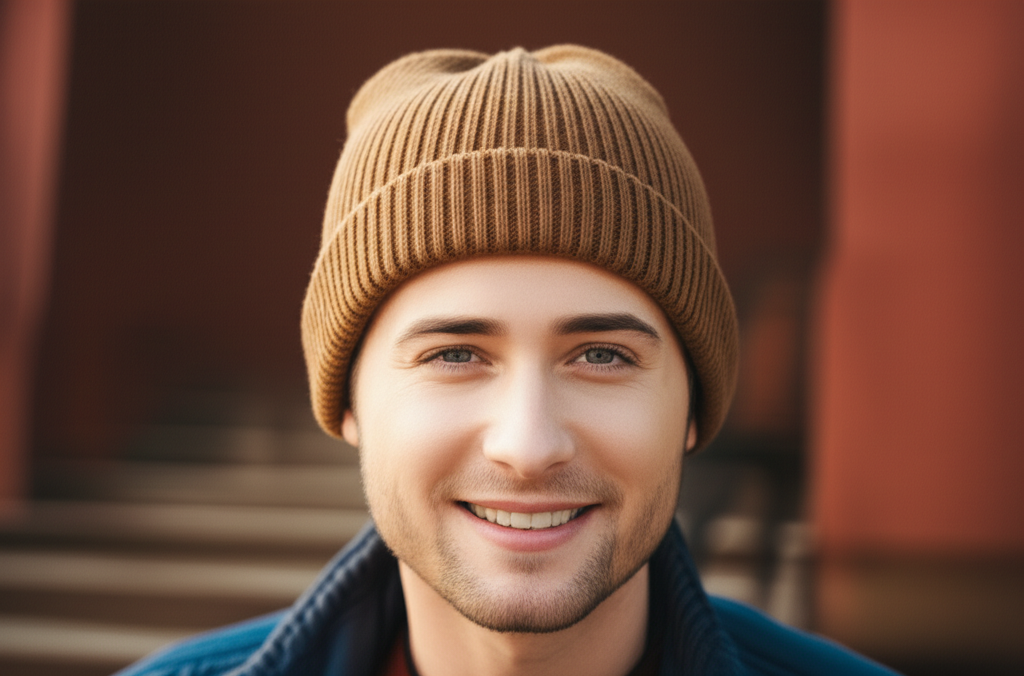

In [9]:
next_message = {
    "role": "user",
    "content": "Can you take the same image and make the man ?",
}

response = llm.invoke(
    [message, response, next_message],
    generation_config=dict(response_modalities=["TEXT", "IMAGE"]),
)

image_base64 = _get_image_base64(response)
display(Image(data=base64.b64decode(image_base64), width=300))

# **Tool Calling**
You can equip the model with tools to call.

In [ ]:
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI


# Define the tool
@tool(description="Get the current weather in a given location")
def get_weather(location: str) -> str:
    return "It's sunny."


# Initialize the model and bind the tool
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools([get_weather])

# Invoke the model with a query that should trigger the tool
query = "What's the weather in San Francisco?"
ai_msg = llm_with_tools.invoke(query)

# Check the tool calls in the response
print(ai_msg.tool_calls)

# Example tool call message would be needed here if you were actually running the tool
from langchain_core.messages import ToolMessage

tool_message = ToolMessage(
    content=get_weather(*ai_msg.tool_calls[0]["args"]),
    tool_call_id=ai_msg.tool_calls[0]["id"],
)
llm_with_tools.invoke([ai_msg, tool_message])  # Example of passing tool result back

[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'e91578b2-e5c5-4c8f-bf1e-90d0b2225f62', 'type': 'tool_call'}]


/tmp/ipython-input-2757231086.py:26: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  content=get_weather(*ai_msg.tool_calls[0]["args"]),


AIMessage(content="OK. It's sunny in San Francisco.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--68ce1d88-e963-4ec4-8109-cedb410a25ba-0', usage_metadata={'input_tokens': 31, 'output_tokens': 11, 'total_tokens': 42, 'input_token_details': {'cache_read': 0}})

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI


# Define the desired structure
class Person(BaseModel):
    """Information about a person."""

    name: str = Field(..., description="The person's name")
    height_m: float = Field(..., description="The person's height in meters")


# Initialize the model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
structured_llm = llm.with_structured_output(Person)

# Invoke the model with a query asking for structured information
result = structured_llm.invoke(
    "Who was the 16th president of the USA, and how tall was he in meters?"
)
print(result)

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


name='Abraham Lincoln' height_m=1.93
